### 令和6年6月30日(日)
不要な特徴量の削除
線形回帰によって得た結果を新たな特徴量とする

PCA分析の結果を特徴量に加える

#### 1. 読み込み

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors , KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
# LGBMClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from hyperopt import hp, fmin, tpe, Trials
import warnings
import sys
sys.path.append('../')
from my_utils import MyUtils
warnings.filterwarnings('ignore')

INPUT_DIR = "../input/"
RANDOM_STATE = 10
OUTPUT_PATH = "C:/Users/gwsgs/workSpace/GCIcomp2/02.（公開）コンペ2/output/"
remove_outliers_columns = [ "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "DAYS_ID_PUBLISH",]
exel_path = 'score_record.xlsx' 
utils = MyUtils(input_path=INPUT_DIR, output_path=OUTPUT_PATH, exel_path=exel_path)  
params = utils.params

In [2]:
# データの読み込み
train, test, X_train, y_train, sample_sub = utils.load_data()
HAS_NAN_INIT = utils.missing_columns() # 欠損値を含む特徴量
NUMERICAL_VARIABLES = train.select_dtypes(include=[np.number]).columns.tolist() # 数値変数を含む特徴量
# 量的データの特徴量
BINARY_FEATURES = [col for col in NUMERICAL_VARIABLES if train[col].nunique() == 2] # 2値変数
NUMERICAL_FEATURES = [col for col in NUMERICAL_VARIABLES if not col in (BINARY_FEATURES,"SK_ID_CURR", "TARGET")] # 量的データ
NUMERICAL_HAS_NAN = [col for col in NUMERICAL_FEATURES if col in HAS_NAN_INIT] # 欠損値を含みかつ数値データである特徴量
CATEGORICAL_FEATURES = train.select_dtypes(exclude=[np.number]).columns.tolist() # カテゴリカル変数を含む特徴量
CATEGORICAL_HAS_NAN = [col for col in CATEGORICAL_FEATURES if col in HAS_NAN_INIT] # 欠損値を含みかつカテゴリカルデータである特徴量

#### 2. 前処理と特徴量作成

In [3]:
# 外れ値の除去
train = utils.remove_outliers(train, remove_outliers_columns, quantile=0.99999)

AMT_INCOME_TOTAL_(171202,)
外れ値：113305    13500000.0
159447     9000000.0
Name: AMT_INCOME_TOTAL, dtype: float64
AMT_CREDIT_(171202,)
外れ値：43096     4050000.0
78154     4050000.0
99845     4050000.0
128408    4050000.0
151153    4050000.0
155895    4050000.0
165141    4050000.0
Name: AMT_CREDIT, dtype: float64
AMT_ANNUITY_(171202,)
外れ値：33614     230161.5
128408    258025.5
Name: AMT_ANNUITY, dtype: float64
DAYS_ID_PUBLISH_(171202,)
外れ値：26886   -6383
30640   -7197
Name: DAYS_ID_PUBLISH, dtype: int64


In [4]:
# 特徴量の作成
# CODE_GENDERが1かつNAME_FAMILY_STATUSがmarriedの場合 = 1,  新しく特徴量[female_marride]を作成
# OCCUPATION_TYPEのLow-skill Laborersを1、それ以外を0に変換。新しく特徴量[is_low_skill]を作成
train["is_low_skill"] = train["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)
test["is_low_skill"] = test["OCCUPATION_TYPE"].apply(lambda x: 1 if x == "Low-skill Laborers" else 0)

# カテゴリカルデータの欠損値をUNKNOWNで補完
for column in CATEGORICAL_HAS_NAN:
    train[column] = train[column].fillna("UNKNOWN")
    test[column] = test[column].fillna("UNKNOWN")

# CODE_GENDERのXNAをUNKNOWNに変換
train["CODE_GENDER"] = train["CODE_GENDER"].replace("XNA", "UNKNOWN")
test["CODE_GENDER"] = test["CODE_GENDER"].replace("XNA", "UNKNOWN")

# カテゴリカルデータをターゲットエンコーディング Holdout Target Encoding https://www.codexa.net/target_encoding/
train, test = utils.target_encoding(train, test, CATEGORICAL_FEATURES, random_state=RANDOM_STATE)

In [5]:
# 数値型の欠損値の補完を行う
train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
# 平均値で欠損を補完
for i in utils.missing_columns():
    train[i].fillna(train[i].median(), inplace=True)
    test[i].fillna(train[i].median(), inplace=True)

In [6]:
# 特徴量の作成
# DAYS_LAST_PHONE_CHANGEを年に変換
train["YEARS_PHONR_CHANGE"] = train["DAYS_LAST_PHONE_CHANGE"] / -365
test["YEARS_PHONR_CHANGE"] = test["DAYS_LAST_PHONE_CHANGE"] / -365
# DAYS_EMPLOYEDを年に変換
train["YEARS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 365
test["YEARS_EMPLOYED"] = test["DAYS_EMPLOYED"] / 365
# DAYS_REGISTRATIONを年に変換
train["YEARS_REGISTRATION"] = train["DAYS_REGISTRATION"] / -365
test["YEARS_REGISTRATION"] = test["DAYS_REGISTRATION"] / -365
# DAYS_ID_PUBLISHを年に変換
train["YEARS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"] / -365
test["YEARS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"] / -365
#  1 if AMT_GOODS_PRICEnan==nan other = 0
train["AMT_GOODS_PRICE_ISNAN"] = train["AMT_GOODS_PRICE"].isnull().astype(int)
test["AMT_GOODS_PRICE_ISNAN"] = test["AMT_GOODS_PRICE"].isnull().astype(int)
# own car and realty = 4 , own realty = 2 , own car = 1 , other = 0 commentと異なる
train["OWN_CAR_REALTY"] = train["FLAG_OWN_CAR"] + train["FLAG_OWN_REALTY"]
test["OWN_CAR_REALTY"] = test["FLAG_OWN_CAR"] + test["FLAG_OWN_REALTY"]
# DAYS_EMPLOYEDが0以上の場合、1 それ以外は0
train["not_employed"] = train["DAYS_EMPLOYED"].apply(lambda x: 1 if x > 0 else 0)
test["not_employed"] = test["DAYS_EMPLOYED"].apply(lambda x: 1 if x > 0 else 0)




# 参考 https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64821
# AMT_CREDITとAMT_ANNUITYの比率
train["CREDIT_TO_ANNUITY_RATIO"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["CREDIT_TO_ANNUITY_RATIO"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# AMT_CREDITとAMT_GOODS_PRICEの比率
train["CREDIT_TO_GOODS_RATIO"] = train["AMT_CREDIT"] / train["AMT_GOODS_PRICE"]
test["CREDIT_TO_GOODS_RATIO"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
# AMT_CREDITとAMT_ANNUITYの比率
train["AMT_CREDIT_TO_AMT_ANNUITY"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["AMT_CREDIT_TO_AMT_ANNUITY"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# DAYS_BIRTH/ -365
train["YEARS_BIRTH"] = train["DAYS_BIRTH"] / -365
test["YEARS_BIRTH"] = test["DAYS_BIRTH"] / -365

In [7]:
days_feature = ["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH"]
# # 年単位でビニング
# train = utils.from_days_to_year_bin(train, days_feature)
# test = utils.from_days_to_year_bin(test, days_feature)
# 月単位でビニング
train = utils.from_days_to_month_bin(train, days_feature)
test = utils.from_days_to_month_bin(test, days_feature)
# 週単位でビニング
train = utils.from_days_to_week_bin(train, days_feature)
test = utils.from_days_to_week_bin(test, days_feature)

In [8]:
# 線形回帰によって新たな特徴量を作成
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
model = LinearRegression()
model.fit(X, y)
train['lr'] = model.predict(X_train)
test['lr'] = model.predict(X_test)

In [9]:
X_train, X_valid, y_train, y_valid, X_test, X, y = utils.split_data(train, test)

### 3. 観察

In [10]:
print(f"X_train:{X_train.shape}")
print(f"X_valid:{X_valid.shape}")
print(f"X_test:{X_test.shape}")
print(f"X:{X.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_valid:{y_valid.shape}")
print(f"y:{y.shape}")
print(f"train:{train.shape}")
print(f"test:{test.shape}")

X_train:(119841, 71)
X_valid:(51361, 71)
X_test:(61500, 71)
X:(171202, 71)
y_train:(119841,)
y_valid:(51361,)
y:(171202,)
train:(171202, 72)
test:(61500, 71)


In [11]:
# import sweetviz as sv

# # Sweetvizの分析レポートを作成（学習データとテストデータの比較、目的変数を指定）
# report = sv.compare([train, "Train Data"], [test, "Test Data"], target_feat='TARGET')

# # レポートをHTMLファイルとして保存
# report.show_html(open_browser=True)

<Axes: xlabel='EXT_SOURCE_1', ylabel='DAYS_BIRTH_bin_week'>

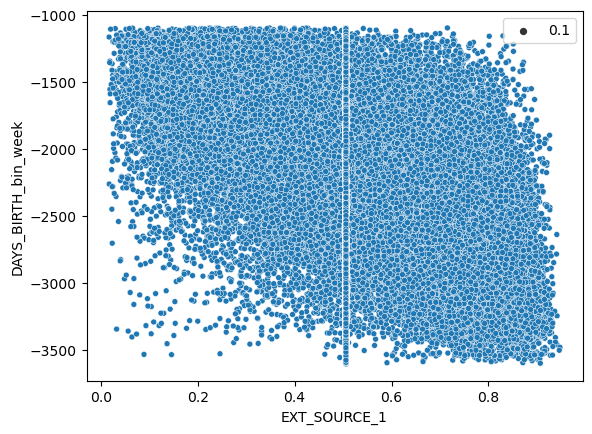

In [12]:
sns.scatterplot(data=train, x='EXT_SOURCE_1',y='DAYS_BIRTH_bin_week', size=0.1)

## 4. 予測

In [13]:
# 複数のモデルを使って予測値を出力
utils.multi_model_predict(X_train, y_train, X_valid, y_valid, all=True)

TypeError: CatBoostClassifier.__init__() got an unexpected keyword argument 'varbose'

In [16]:
def objective(args):
    lgb = LGBMClassifier(
        num_leaves = args['num_leaves'],
        max_depth = args['max_depth'],
        n_estimators = args['n_estimators'],
        learning_rate = args['learning_rate'],
        # min_child_samples = args['min_child_samples'],
        reg_lambda = args['reg_lamb'],
        bagging_freq = args['bagging_freq'],
        bagging_fraction = args['bagging_fraction'],
        feature_fraction = args['feature_fraction'],
        min_data_in_leaf = args['min_data_in_leaf'],
        random_state = params['random_state'],
        objective = params['objective'],
        metric = params['metric'],
        verbosity = params['verbosity'],
        boosting_type = params['boosting_type'],
        early_stopping_round = 50
        )
    lgb.fit(X_train, y_train,
            eval_set = [(X_valid, y_valid)]
        )
    lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, lgb_valid_pred)
    return -1.0 * auc   

In [17]:
import datetime
n_iter = 100
trials = Trials()
time = datetime.datetime.now().strftime('%Y%m%d%H%M')
best = fmin(
    objective,
    space = params,
    algo=tpe.suggest,
    max_evals=n_iter,
    trials=trials,
    verbose=-1, # 試行の過程を出力
    early_stop_fn=None,
    show_progressbar = True,
    # trials_save_file=f"{output_path}_trials_save_file_{time}.pkl"
)

100%|██████████| 100/100 [09:14<00:00,  5.54s/trial, best loss: -0.7609288656508069]


In [ ]:
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
lgb = LGBMClassifier(
        learning_rate = best['learning_rate'],
        objective = params['objective'],
        max_depth = best['max_depth'],
        # min_child_samples = best['min_child_samples'],
        n_estimators = best['n_estimators'],
        num_leaves = best['num_leaves'],
        reg_lambda= best['reg_lamb'],
        bagging_freq = best['bagging_freq'],
        bagging_fraction = best['bagging_fraction'],
        feature_fraction = best['feature_fraction'],
        min_data_in_leaf = best['min_data_in_leaf'],
        verbose = -1,
        random_state = RANDOM_STATE,)
lgb.fit(X, y)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(best)
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

{'bagging_fraction': 0.8573034096313998, 'bagging_freq': 7, 'feature_fraction': 0.4989029114999938, 'learning_rate': 0.14271247521243238, 'max_depth': 2, 'min_data_in_leaf': 95, 'n_estimators': 1150, 'num_leaves': 50, 'reg_lamb': 39.77763227678911}
Train Score: 0.7907403452839621
Valid Score: 0.7891356159911201


In [ ]:
utils.save_score_to_exel(utils.exel_path, best, trials.best_trial['result']['loss'] * -1, time)

In [ ]:
dic = {}
for i,  column in enumerate(test.columns):
    dic[i] = column
dic

{0: 'SK_ID_CURR',
 1: 'NAME_CONTRACT_TYPE',
 2: 'CODE_GENDER',
 3: 'FLAG_OWN_CAR',
 4: 'FLAG_OWN_REALTY',
 5: 'CNT_CHILDREN',
 6: 'AMT_INCOME_TOTAL',
 7: 'AMT_CREDIT',
 8: 'AMT_ANNUITY',
 9: 'AMT_GOODS_PRICE',
 10: 'NAME_TYPE_SUITE',
 11: 'NAME_INCOME_TYPE',
 12: 'NAME_EDUCATION_TYPE',
 13: 'NAME_FAMILY_STATUS',
 14: 'NAME_HOUSING_TYPE',
 15: 'REGION_POPULATION_RELATIVE',
 16: 'DAYS_BIRTH',
 17: 'DAYS_EMPLOYED',
 18: 'DAYS_REGISTRATION',
 19: 'DAYS_ID_PUBLISH',
 20: 'OWN_CAR_AGE',
 21: 'FLAG_MOBIL',
 22: 'FLAG_EMP_PHONE',
 23: 'FLAG_WORK_PHONE',
 24: 'FLAG_CONT_MOBILE',
 25: 'FLAG_PHONE',
 26: 'FLAG_EMAIL',
 27: 'OCCUPATION_TYPE',
 28: 'CNT_FAM_MEMBERS',
 29: 'REGION_RATING_CLIENT',
 30: 'REGION_RATING_CLIENT_W_CITY',
 31: 'REG_REGION_NOT_LIVE_REGION',
 32: 'REG_REGION_NOT_WORK_REGION',
 33: 'LIVE_REGION_NOT_WORK_REGION',
 34: 'REG_CITY_NOT_LIVE_CITY',
 35: 'REG_CITY_NOT_WORK_CITY',
 36: 'LIVE_CITY_NOT_WORK_CITY',
 37: 'ORGANIZATION_TYPE',
 38: 'EXT_SOURCE_1',
 39: 'EXT_SOURCE_2',
 40:

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

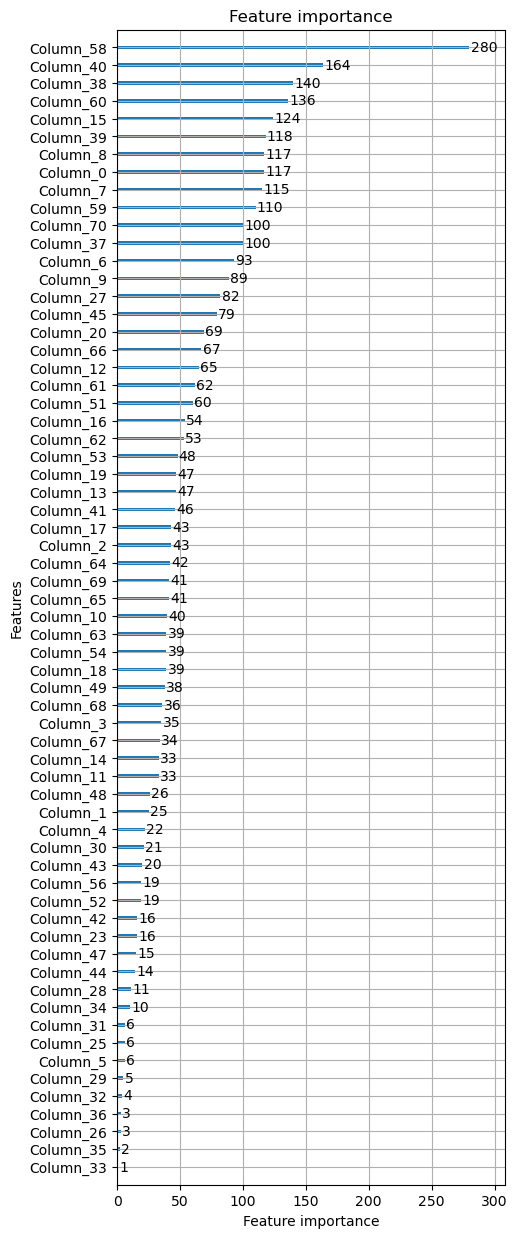

In [ ]:
lgbm.plot_importance(lgb,figsize=(5, 15))

#### 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [ ]:
# テストデータに対する予測値の作成
# pred = lgb.predict_proba(X_test, num_iteration=lgb.best_iteration)[:, 1]
pred = lgb.predict_proba(X_test)[:, 1]

In [ ]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred

In [ ]:
# 提出用のcsvファイルを作成
# formatを指定して現在時刻を取得（yyyyMMddhhmm）
sample_sub.to_csv(f'{OUTPUT_PATH}/{time}.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！